# Recommendation Engine for Board Game Text Data

This project builds off of the Recommendation Project, and the Natural Language Processing on Wikipedia comments.

This is using data from boardgamegeek.com, gathered by Matt Borthwick.  The real goal here is to finish an analysis.
This is labelled data for game, so it's a natural fit for employing the same methods as toxicity, and run with that analysis.

## Outline/Planning

What is my ultimate goal here? 
- Build a recommendation engine based on reviews/scores.
- Give score to unrated comments.

My rough plan is to build up a lexicon, tokenize that data, and try to build a Naive Bayes model.  (Maybe later a Recurrent Neural network model?)

Cleaning:
* Tokenize (convert words to indices) 
* Stemming words
* Balancing data set

Embeddings:
These are necessary to reduce the dimensionality of the problem to a scale that will fit in memory.  
   * SVD - use SVD on the term-frequency matrix. Will use truncated SVD.  
   * word2vec - train vectors for words based on surrounding contexts (can use pre-trained ones, like GLoVE)
   * Keep only most common words (in both toxic/non-toxic), or highest probability of toxic/non-toxic

Other Analysis possibilities:
* Naive Bayes
    - can find most important words
    - simple, easy to understand baseline.
* Support Vector Machine
    - try ensemble method (split the data into batches, and train an SVM on each batch.  Then do a committee vote.)
      This turns O(n_sample^3) scaling into O(n_sample^3/n_batch^2) scaling on the training.
      This is effectively treating the kernel matrix as if it were block-diagonal, as it omits correlations between datasets.
      Perhaps running multiple copies with different random splits would work?
* Deep Neural Network
    - Build a network using the term-frequency matrix as inputs.
    - Extends the naive Bayes method.  (Might be automatic way of doing some of that SVM stuff?)
    - Employ dropout for regularization, alongside L2 penalties.  
     
* Recurrent Neural Network
    - Build up word embeddings (word2vec), or just use the pretrained ones.
    - This one runs at the sentence/paragraph level and keeps the temporal structure.
    - Use LSTM/GRU cells, with a couple layers. 
    - Also dropout, l2 penalties

Metrics:
    - F1 :harmonic mean of precision and recall
    - log-loss $N^{-1}\sum_{j=1}^N\sum_c y_{jc}\log \hat{y}_{jc}$, where $j$ runs over observations, and $c$ runs over classes.


# Loading in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import log_loss,f1_score,roc_auc_score

from IPython.display import clear_output
import time

#my code
from bayes import cond_prob, naive_bayes
from util import clean_up, get_subset, check_predictions
%load_ext autoreload
%autoreload 2

In [51]:
df = pd.read_csv('data/boardgame-comments-english.csv')

df_real_test=pd.read_csv('data/boardgame-comments-english-test.csv')

In [54]:
df_real_test.head()

   Compiled from boardgamegeek.com by Matt Borthwick  gameID  \
0                                             140134  205637   
1                                             184733    2163   
2                                              17204   15158   
3                                              79036   35677   
4                                             188085  155426   

                                                                                              comment   
0  This game is the first game that totally left me satisfied after I played it.  This one hit the ...  
1  I got into this game just as the first edition went out of print. So I was only able to buy the ...  
2  This expansion has some edges but I like it because it forces you to change tactics when the dra...  
3  Why bother with Le Havre if you can play Agricola? Sorry, I have to say it. The theme in Agricol...  
4  Fun enough to discover and tinker around with. But approaching it as a game means grind

In [55]:
df.columns=['userID','gameID','rating','comment']
df_real_test.columns=['userID','gameID','comment']

In [20]:
df.head()

   userID  gameID  rating  \
0  172640   24068     7.0   
1   86674   24068     7.0   
2   10643   24068     7.0   
3   31171   24068     7.0   
4  165608   24068     7.0   

                                                                                               comment  
0  Good:  Unique take on the hidden role games. The good and evil team win if they eliminate each o...  
1  A neat social deduction game with multiple teams and winning conditions happening at the same time.  
2  Good hidden roles werewolf style game that can accommodate a lot of players nicely. This game is...  
3  Overall I hate Mafia/Werewolf, but this version is light, fun and fast. There was enough structu...  
4  Fun social deduction exercise that gets merrier the more players participate. The game significa...  

In [4]:
#When are the comments made?
plt.figure()
df['rating'].hist(log=True,bins=101)
plt.title('Rating Histogram')
plt.show()

So let's do more exploration.  

In [5]:
#Number of unique Users
df['userID'].unique().shape

(59789,)

In [6]:
df['gameID'].unique().shape

(402,)

In [5]:
userreview_counts=df.groupby('userID').apply(len)

In [6]:
# How many reviews are there per user?
userreview_counts.hist(log=True,bins=50)
plt.show()

So, there are a lot of users with few reviews (again).

This will come up in building a test/train split.  It depends on the task.  Are we trying to build a tool to recommend games? 

In [9]:
#check counts of game reviews
game_groups=df.groupby('gameID')

In [10]:
gamereview_counts=game_groups.apply(len)
gamereview_mean=game_groups['rating'].apply(np.mean)
gamereview_median=game_groups['rating'].apply(np.median)
gamereview_05=game_groups['rating'].apply(lambda x: np.percentile(x,5))
gamereview_95=game_groups['rating'].apply(lambda x: np.percentile(x,95))


In [11]:
# How many reviews are there per game?
plt.hist(np.log10(gamereview_counts+1),bins=50)
plt.xlabel('Log10 number of reviews per game')
plt.show()


In [12]:
plt.plot(np.log10(gamereview_counts),gamereview_mean,'x')
plt.show()

In [281]:
df_small=df.iloc[:1000].copy()

In [17]:
#cleaning the data
#Can use pandas built in str functionality with regex to eliminate html tags, newlines, non-text characters. 
#Can maybe also eliminate all punctuation?  Makes any 
df['comment_clean']=clean_up(df['comment'])


In [56]:
df_real_test['comment_clean']=clean_up(df_real_test['comment'])

# Split data set into train/dev/test sets

Let's grab 10% of the data for development, and 10% for training.
Once again, we have to be 

In [19]:

np.random.seed(seed=4565)
#Split into test/training.
Ntot=len(df)
Ntrain=int(0.9*Ntot)

msk=np.random.random(Ntot)<0.9
df_train=df.loc[msk]
df_test=df.loc[~msk]


In [14]:
#take care of low ratings so minimum is 1.
msk=df['rating']<1.0;
df.loc[msk,'rating']=1

#create binary labels for rating.
df['pos']=(df['rating']>8.0)
df['neg']=(df['rating']<5.0)

So let's vectorize this sucker.
Since this is primarily for exploration, I'm going to limit the vectorizer to fairly common words (which occur in more than 50 messages).
Increasing this threshold seems to pull out more meaningful estimates for the conditional probabilities for positive and negative words.

It's also possible to not just use  the raw count vectorizer, but also the TF-IDF, which includes an additional weighting that de-emphasizes common words.  This apparently makes a term-frequency matrix whose spectrum better matches some of the assumptions for the SVD.  

In [275]:
?CountVectorizer

In [58]:
?CountVectorizer

In [20]:
#borrowing from http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
count_vect=CountVectorizer(stop_words='english',lowercase=True,strip_accents='unicode',ngram_range=(1,2),min_df=20)
X_train_counts=count_vect.fit_transform(df_train['comment_clean'])
X_test_counts=count_vect.transform(df_test['comment_clean'])


So one of the problems with going to multiple n-grams is the ease with which you start overfitting.
Maybe I could explore adjusting this size manually, with the size of ngrams,   

In [365]:
tfidf_vect=TfidfVectorizer(stop_words='english',lowercase=True,strip_accents='unicode',min_df=50)
X_train_tfidf=tfidf_vect.fit_transform(df_train['comment_clean'])
X_test_tfidf=tfidf_vect.transform(df_test['comment_clean'])

In [57]:
X_realtest_counts=count_vect.transform(df_real_test['comment_clean'])

In [292]:
if (X_train_counts.shape[0]!=df_train.shape[0]):
   print('Lost some entries from training set!')
if (X_test_counts.shape[0]!=df_test.shape[0]):
   print('Lost some entries from training set!')

# Checking the vectorizer and finding common words

I wanted to check that the vectorizer was working by outputting common words, and identifying the "most positive/negative" words, based on their counts.  This was useful as a sanity check.

In [207]:
#get vocabulary dictionary, then make a dataframe, with entries as rows
#Then sort dataframe by row entry value, and then use that as the index for the counts.


In [21]:
def find_indicator_words(counts,val,count_vect):
    voc_dict=count_vect.vocabulary_
    voc_df=pd.DataFrame.from_dict(voc_dict,orient='index')
    voc_df1=voc_df.sort_values(by=0)
    #Compute conditional probabilities of toxicity for each word. 
    p_pos,pw_pos,pw_neg = cond_prob( counts, val, csmooth=0.000001)
    #make new dataframe with conditional probabilities for words being toxic, and raw probabilities of occuring in toxic/clean messages
    #Then sort by toxicity.
    X_cond= pw_pos*p_pos/(pw_pos*p_pos + pw_neg*(1-p_pos))
    word_mat=np.array([counts.sum(axis=0),X_cond,pw_neg,pw_pos]).squeeze()
    word_df=pd.DataFrame(word_mat.T,columns=['count','pcond','p_hit','p_miss'],index=voc_df1.index)
    word_df.sort_values('pcond',ascending=False,inplace=True)
    print(word_df.head(n=20))
    return word_df

In [22]:
posword_df=find_indicator_words(X_train_counts,df_train['pos'].values,count_vect)

                      count     pcond         p_hit    p_miss
rate 11                38.0  1.000000  6.504739e-14  0.000007
user malain            29.0  1.000000  6.504739e-14  0.000006
damaging ranking       29.0  1.000000  6.504739e-14  0.000006
malain random          29.0  1.000000  6.504739e-14  0.000006
ranking unknown        29.0  1.000000  6.504739e-14  0.000006
random 1s              29.0  1.000000  6.504739e-14  0.000006
1s bunch               29.0  1.000000  6.504739e-14  0.000006
correcting rating      29.0  1.000000  6.504739e-14  0.000006
malain                 29.0  1.000000  6.504739e-14  0.000006
rating user            29.0  1.000000  6.504739e-14  0.000006
players 2017           21.0  1.000000  6.504739e-14  0.000004
simply greatest        21.0  1.000000  6.504739e-14  0.000004
simply favorite        20.0  1.000000  6.504739e-14  0.000004
unknown games          31.0  0.965064  6.504745e-08  0.000006
really damaging        30.0  0.963903  6.504745e-08  0.000006
jlnelson

Some of these positive words aren't very helpful.  For example "boardgameexpansion" seems to come from urls.
"eldadodejack" is some guys website.  Otherwise, these are also the names of the games!

In [23]:
negword_df=find_indicator_words(X_train_counts,df_train['neg'].values,count_vect)

                         count     pcond         p_hit    p_miss
smjj                      82.0  1.000000  5.273352e-14  0.000051
smjj loves                53.0  1.000000  5.273352e-14  0.000033
inanimate unintelligent   29.0  1.000000  5.273352e-14  0.000018
unsatisfied id            28.0  1.000000  5.273352e-14  0.000017
algorithm left            28.0  1.000000  5.273352e-14  0.000017
random inanimate          28.0  1.000000  5.273352e-14  0.000017
unintelligent algorithm   28.0  1.000000  5.273352e-14  0.000017
thanks smjj               26.0  1.000000  5.273352e-14  0.000016
puzzles win               30.0  0.964691  5.273357e-08  0.000018
inanimate                 34.0  0.937787  1.054671e-07  0.000020
unintelligent             33.0  0.904041  1.582006e-07  0.000019
basis waste               21.0  0.899498  1.054671e-07  0.000012
versus team               65.0  0.854271  4.746017e-07  0.000035
luck boring               21.0  0.849685  1.582006e-07  0.000011
boring boring            

So let's look at what this pulled out for "negative words".

There are expressions of boredom: "interminable, torture, numbingly".
Disgust: "yuck, blech, garbage,ugh"
Dislike:"torture, garbage, hatred, loathe"

One of these might be a user's name: smjj. Perhaps from a genius who protests giving scores at all and gives everything 1.

In [24]:
def find_words(df,st):
    msk=df['comment_clean'].str.contains(st)
    print(df[msk].head())
    print(df[msk].tail())

In [25]:
find_words(df_train,'eldadodejack')

       userID  gameID  rating  \
12684   86991   10630     9.0   
12761   86991  105551     9.0   
26337   86991    1927     8.0   
40390   86991  157354     9.0   
62266   86991  150376    10.0   

                                                                                                   comment  \
12684  Wonderfully elegant and light wargame. Simple enough to make it accessible to everyone while lea...   
12761  It's got some very good heavy euro mechanisms tied to a strong theme and with a great deal of ne...   
26337  Fun if played for laughs with the right group of people. If you try to play it "seriously" or de...   
40390  The best Feld game I've ever played was not designed by Feld. Shocking.  Spanish review: http://...   
62266  A game that redefines hidden roles, focusing more on personal conflict and storytelling than on ...   

         pos    neg  \
12684   True  False   
12761   True  False   
26337  False  False   
40390   True  False   
62266   True  False   

 

So, we've evidently found someone who rates all games 1, or 10, and their enemies squabbling.
Eliminating some duplicates will help with this for the text rating purpose. 

Look like there is also some markup garbage in there as well from fancier reviews, or people linking to google docs where they might have their own ratings.  Some leftover html as well.  

# K-folds

Let's split the training data into k-folds so we can do some cross-validation for tuning hyper-parameters.
This will primarily show up on tuning the vectorization procedure, and any fitting hyper parameters (regularization).
For Naive Bayes, there aren't any parameters, but this will be useful for the neural networks, and setting the penalty.
I'll 

In [26]:
from sklearn.model_selection import StratifiedKFold

In [27]:
skf=StratifiedKFold(n_splits=5,random_state=20483)
#grab the first iteration here.
train_index, dev_index=skf.split(df_train, df_train['pos']).__next__()

In [28]:
df_train0=df_train.iloc[train_index]
df_dev0=df_train.iloc[dev_index]

# Naive Bayes Classifier

I want to implement a Naive Bayes classifier as a baseline.  I've written my own version, which I will try to compare to
scikit-learn's version.  (They both return the same result now).

This basically treats the comments in a bag-of-words sense, and drops any correlations between the words.  

* Estimate $p(w|T)$ from counts in term-frequency matrix.
* Use Bayes Rule
  $ P(T|w) = \frac{p(T)p(w|T)}{\text{normalization const}}$

  \begin{equation}
    p(T|\text{words}) = P(T) \prod_{words}\frac{p(w_i|T)}{p(w_i|T)
  \end{equation}

* Use Logarithms, and compare log-odds for toxicity/non-toxic.

So this is a classification point of view.  Ultimately, we want to treat this as a regression problem.
A classification algorithm is a poor fit for this, since it ignores the similarity between adjacent scores. 
Nonetheless, I have a working version, so let's play with that.

In [29]:
#go though this split, and find the hits
actual=df_train0['pos'].values
actual_dev=df_dev0['pos'].values
msk=actual
#find indices for both split and hit.
train_hit_msk=train_index[msk]
Xhit = X_train_counts[train_index]
#compute conditional probabilities within this sample
p_hit,pw_hit,pw_miss = cond_prob( Xhit, actual, csmooth=0.000001)
#now compute the bayes factors
pred,prob,logH,logM,log_Hword,log_Mword=naive_bayes(Xhit,pw_hit,pw_miss,p_hit)    

/home/jonathan/Data-Science/PDSG_DataScience/PDSG_rectext/bayes.py:57: RuntimeWarning: overflow encountered in exp
  prob=1/(1+np.exp(log_Cscore-log_Tscore))


In [30]:
#Plot a histogram of the log probabilities.  
plt.figure()
plt.hist(np.maximum(-10,np.log(prob)),bins=100)
plt.show()

/home/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
#Plot a histogram of the log-odds 
plt.figure()
bins=np.linspace(-50,50,100)
plt.hist(logH-logM,bins=bins,log=True)
plt.ylabel('Counts')
plt.xlabel('Log Odds of Hit')
plt.show()

In [ ]:
Maybe should also plot length of comments? To what extent are these mirroring a similar underlying shape, with long tails?

In [32]:
com_len=df_train['comment_clean'].apply(lambda x: len(str.split(x,' ')))
plt.hist(np.log10(com_len),log=True)
plt.xlabel('Log-Character length of message')
plt.show()

In [33]:
logloss,score_rates=check_predictions(pred,actual)

Log-loss is 7.2079829918574685
AUROC is 0.7282859065985177


(606412, 1) (606412, 1)
True Positive 0.1442995851005587. False Positive 0.1158041067788896
False Negative 0.092885694874112. True Negative 0.6470106132464397


Interesting. The mean log-loss is surprisingly sensitive to the chosen zero-offset.  I think this reflects the fact that the naive-bayes method is returning a lot of incredibly small probabilities (10^{-100}).

In [34]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=0.01)
nb.fit(X_train_counts[train_index],df_train0['pos'].values)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [35]:
#Make predictions on training/dev sets
pred_nb=nb.predict(X_train_counts[train_index])
pred_dev_nb=nb.predict(X_train_counts[dev_index])

In [36]:
print('Checking Training data')
nb_stats=check_predictions(pred_nb,actual)

Log-loss is 7.216298741049285
AUROC is 0.7281041422199969


Checking Training data
(606412, 1) (606412, 1)
True Positive 0.14428309466171513. False Positive 0.116028376747162
False Negative 0.09290218531295555. True Negative 0.6467863432781673


One of the errors I've found comes from when the vectorizer transforms a sentence with no recognized words.  Those sentences are lost.  The sparse algorithm ditches those rows? 

In [37]:
print('Checking dev set')
nb_stats=check_predictions(pred_dev_nb,actual_dev)

Checking dev set
(151604, 1) (151604, 1)
True Positive 0.13168517981055908. False Positive 0.12603229466240995
False Negative 0.10549853565868975. True Negative 0.6367839898683412
Log-loss is 7.996892352087403
AUROC is 0.6949917852372789


So how is that doing?  What fraction have reviews 

In [327]:
np.mean(actual)

0.43027677552555027

## Naive Bayes False Positives and Negatives

Let's now look a bit at the misclassified results.

In [38]:
#fixing shapes to avoid broadcasting
actual=np.reshape(actual,(len(actual),1))
pred=np.reshape(pred,(len(actual),1))    

fp_msk = ((pred==True)&(actual==False))    
fn_msk = ((pred==False)&(actual==True))            

In [39]:
df_fn=df_train0[fn_msk][['comment','rating']]
df_fp=df_train0[fp_msk][['comment','rating']]

In [40]:
df_fp.head()

                                                                                                    comment  \
168250                                                      + Pandemic: In the Lab + Pandemic: On the Brink   
168253  First game design that blew my mind. Instant classic for me and everyone I show it to. I should ...   
168278  Clearly deserving of all the plaudits (and I don't care much for the BIG DEBATE)  An outstanding...   
168282  First game of Age of Steam. Great game, great tension, and there are obviously some mistakes tha...   
168290  It's been a long time since i've had such a good impression about a game. It is a game of managi...   

        rating  
168250     7.0  
168253     7.0  
168278     6.0  
168282     6.0  
168290     6.0  

In [344]:
df_fn.head()

                                                                                                    comment  \
167395                  I really enjoyed it but i have only played it once and i would like to play again!    
167405  Not a big fan of deckbuilders, nor do I typically like one one one destruction confrontation, bu...   
167406  1000 games @ 57% win rate on the app. Unsure if that is a good result or just perserverance. upd...   
167408  I like this deckbuilding game a lot, and I've played it a ton digitally. It's small enough to ea...   
167412                                                                                         Now on iPad.   

        rating  
167395     9.5  
167405     8.0  
167406     8.0  
167408     8.0  
167412     8.0  

In [ ]:
## Multiple Classes

For fun, let's try putting each review into a bucket based on the score, and build a Naive Bayes classifier for each bin.


In [42]:
Ytrain=np.floor(df_train['rating']*2).values.astype(int)
Ytrain0=Ytrain[train_index]
Ydev0=Ytrain[dev_index]

In [43]:
nb_all = MultinomialNB(alpha=0.01)
nb_all.fit(X_train_counts[train_index],Ytrain0)


MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [44]:
pred_nb_all=nb_all.predict(X_train_counts[train_index])/2
pred_dev_nb_all=nb_all.predict(X_train_counts[dev_index])/2

In [59]:
def errors(x,y):
    rmse=np.sqrt(np.mean( (x-y)*(x-y)))
    mad=np.mean(np.abs(x-y))
    return rmse,mad

In [60]:
errors(pred_nb_all,df_train0['rating'])

(1.4519374478682496, 0.9042549691133924)

In [61]:
errors(7.2,df_train0['rating'])

(1.6923247664589591, 1.2955374099289365)

Let's check this against the development set.

In [64]:
print(errors(pred_dev_nb_all,df_dev0['rating']))

(1.6482452581473976, 1.1801908611250402)
(7.121455623653504, 6.943727082860698)


In [65]:
errors(7.2,df_dev0['rating'])

(1.7017978234173143, 1.3059945541675015)

In [ ]:
So, it does a bit better than the super simple guess.
One of the downsides of this particular problem is that the scores are fairly similar.
These are by and large, good games, so they have good scores. 
People also use the rating scale inconsistently, so there is quite a bit of noise.

I think this (like the previous rating experiment) will struggle to push below this noise floor.
Nor is it really important?  

In [72]:
df['rating'].mean()

7.2016890870378365

In [69]:
#now predict all counts
pred_realtest_nb=nb_all.predict(X_realtest_counts)/2
df_real_test['nb']=pred_realtest_nb

In [73]:
df_real_test['const']=7.2

In [75]:
df_real_test[['userID','gameID','nb']].to_csv('data/nb_test_pred.csv',index=False)
df_real_test[['userID','gameID','const']].to_csv('data/const_test_pred.csv',index=False)


# Linear Regression

We could just face the fact this is a regression problem, and build a linear regressor on the term-frequency matrix.


In [76]:
from sklearn import linear_model

In [78]:
ridge=linear_model.Ridge(alpha=0.01)
lasso=linear_model.Lasso(alpha=0.01)
Y=df_train['rating'].values

## Lasso

Let's try using the lasso. Currently, it seems to just fit the mean.
The lasso is a regularized linear regression, which tends to return sparse models.


In [417]:
Y

array([ 7. ,  7. ,  7. , ...,  7.5,  7.5,  7.5])

In [79]:
lasso.fit(X_train_counts[train_index], Y[train_index])

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [83]:
Lpred=lasso.predict(X_train_counts[train_index])
Lpred_dev=lasso.predict(X_train_counts[dev_index])



(1.5968342564669999, 1.2082255947862153)

In [107]:
Lpred_real_test=lasso.predict(X_realtest_counts)
df_real_test['Lpred']=Lpred_real_test
df_real_test[['userID','gameID','Lpred']].to_csv('data/lasso_test_pred.csv',index=False)

In [86]:
print('Lasso train error:',errors(Lpred,Y[train_index]))
print('Lasso dev error:',errors(Lpred_dev,Y[dev_index]))

Lasso train error: (1.5968342564669999, 1.2082255947862153)
Lasso dev error: (1.603519303584094, 1.2167404918314322)


In [105]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.hist(Lpred,bins=np.arange(1,11),log=True)
plt.title('Lasso Regression')
plt.subplot(132)
plt.hist(pred_nb_all,bins=np.arange(1,11),log=True)
plt.title('Naive Bayes Multiclassification')
plt.subplot(133)
plt.hist(df['rating'],bins=np.arange(1,11),log=True)
plt.title('Actual Rating')
plt.show()

In [81]:
Lpred.std()

0.41411842009948163

# Dimensionality Reduction

Let's use the truncated SVD for dimensionality reduction (or latent semantic analysis?)
Apparently TF-IDF matrix is superior to straight term frequency matrix for this purpose  (more closely matches assumptions in the SVD about the noise.)
Should maybe also symmetrize transformation (as suggested in paper comparing hyperparameters between word2vec and older SVD methods).
They suggest using $T=U \Lambda V = (U \Lambda^{1/2}) (\Lambda^{1/2} V)$ for the projection.  

In [31]:
from sklearn.decomposition import TruncatedSVD
#took a minute or two
TSVD=TruncatedSVD(n_components=100,n_iter=20)
TSVD.fit(X_train_tfidf)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=20,
       random_state=None, tol=0.0)

In [32]:
#actually transform the results 
X_train_trans=TSVD.transform(X_train_tfidf)         

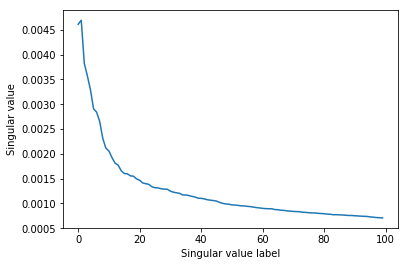

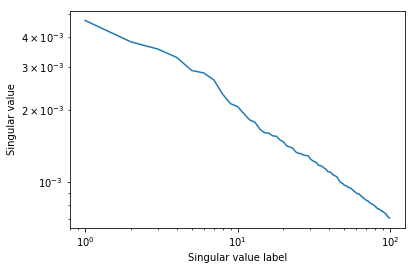

In [33]:
plt.loglog(TSVD.explained_variance_)
plt.xlabel('Singular value label')
plt.ylabel('Singular value')
plt.show()
plt.plot(TSVD.explained_variance_)
plt.xlabel('Singular value label')
plt.ylabel('Singular value')
plt.show()

So looks like power-law decay in the spectrum. We're primarily interested in using this
for dimensionality reduction.  Ideally, I'd pick some reasonable threshold for keeping a
certain fraction of the explained variance.
(Could estimate a power law tail, compute threshold to capture that percentage).

But for now, we'll just set the threshold to be 100, as a suitably small arbitrary choice.  
We will next use the transformed results in a "deep" neural network.  

In [42]:
#actually transform the dev/test data.
X_dev_trans=TSVD.transform(X_dev_tfidf)

In [24]:
Nsub=1000
np.random.seed(454)
#Should really update to just use sklearn's stratified Kfold.


# Deep Network

Another idea is to build a deep neural network on the term-frequency matrix, effectively running with extensions to the Naive Bayes model.
This will use the reduced term-frequency matrix after the Truncated SVD.  

In [43]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, l2_regularizer
from tensorflow.contrib.rnn import BasicRNNCell,LSTMCell

In [44]:
from deep_network import deep_dropout_NN

In [48]:
#Ignore the "error about serializing - this is a known problem with saving models created using 
#modules like fully connected, since their components are not named.
#The models are saved, and the computations work.

actual=df_train['toxic'].astype(int).values
save_name='./tf_models/deep_relu_drop'
dNN=deep_dropout_NN(X_train_trans.shape)
dNN.run_graph(X_train_trans,actual,save_name)

iter #1000. Current log-loss:0.13786394894123077


Type is unsupported, or the types of the items don't match field type in CollectionDef.
'function' object has no attribute 'name'


In [62]:
#model_name='tf_models/deep_relu_drop-{}'.format(dNN.n_iter)
model_name='./tf_models/deep_relu_drop-{}'.format(1000)
dnn_pred2=dNN.predict_all(model_name,X_train_trans)
dnn_pred2=dnn_pred2.reshape(-1)

newer predict
INFO:tensorflow:Restoring parameters from ./tf_models/deep_relu_drop-1000


In [63]:
#Check scores on training data
dnn_conf=check_predictions(dnn_pred2,actual)

True Positive 0.06058354438328066. False Positive 0.006645457019067752
False Negative 0.036105238922494086. True Negative 0.8966657596751575
Log-loss is 1.4765620415427758
AUROC is 0.8096130944597727


In [64]:
#Compare with naive-bayes training
nb_conf=check_predictions(pred_nb,actual)

True Positive 0.08531301672352806. False Positive 0.01651422232454947
False Negative 0.011375766582246687. True Negative 0.8867969943696757
Log-loss is 0.9632992952381051
AUROC is 0.9320323498876192


In [ ]:
Right now the network seems undertrained.

In [ ]:
## Predictions from Deep Neural Network

Let's now run some predictions on the full training and development sets.  

In [66]:
#Try testing on the dev-set
model_name='tf_models/deep_relu_drop-{}'.format(dNN.n_iter)
nn_pred_train = dNN.predict_all(model_name,X_train_trans)
print('4 layer ReLU network: on Dev set')
actual_train=df_train['toxic'].values
nn_pred_train=nn_pred_train.reshape(-1)
nn_stats=check_predictions(nn_pred_train,actual_train)

nn_pred_dev = dNN.predict_all(model_name,X_dev_trans)
print('4 layer ReLU network: on Dev set')
actual_dev=df_dev['toxic'].values
nn_pred_dev=nn_pred_dev.reshape(-1)
nn_stats=check_predictions(nn_pred_dev,actual_dev)

newer predict
INFO:tensorflow:Restoring parameters from tf_models/deep_relu_drop-1000
4 layer ReLU network: on Dev set
True Positive 0.06067773196307847. False Positive 0.006614061159135149
False Negative 0.036011051342696276. True Negative 0.8966971555350901
Log-loss is 1.4722245180949745
AUROC is 0.8101175383672511
newer predict
INFO:tensorflow:Restoring parameters from tf_models/deep_relu_drop-1000
4 layer ReLU network: on Dev set
True Positive 0.05386029984727114. False Positive 0.011594925661565315
False Negative 0.04173549855063429. True Negative 0.8928092759405293
Log-loss is 1.841976868183656
AUROC is 0.7752982535343149


In [67]:
print('Naive Bayes on Dev set')
pred_dev_nb=nb.predict(X_dev_counts)
nb_stats=check_predictions(pred_dev_nb,actual_dev)

Naive Bayes on Dev set
True Positive 0.06311753888352087. False Positive 0.02322102047813484
False Negative 0.032478259514384565. True Negative 0.8811831811239598
Log-loss is 1.9238035444874515
AUROC is 0.8172894153987111


In [ ]:
Prior work with a (3-layer ReLU-tanh) network led to over-fitting to the training set.  Not surprising, since there was no regularization here.
It could outperform the Naive Bayes method on the training set, but had worse performance on the development dataset.

Let's put in some dropout. Putting in dropout after each layer, with a 0.1 dropout probability improved performance.

In [294]:
#dev scores
[f1_score(actual_dev,nn_pred_dev),f1_score(actual_dev,pred_dev_nb)]

[0.63848495096381463, 0.69363963655066008]

In [292]:
print([f1_score(actual,nn_pred_train),f1_score(actual,pred_nb)])
print([f1_score(actual_dev,nn_pred_dev),f1_score(actual_dev,pred_dev_nb)])

[0.75269211943220748, 0.97498410006359981]
[0.68780126065999259, 0.66262049268118539]


I am finding that beyond one or two layers, the network just seems to output zeros.  Maybe the learning rate was too high? Yes - this is a common problem.

# Recurrent Neural Network

So let's try the current flavour of the month approach: a recurrent neural network.
Based on talking to Joseph and Fahim at the group, they used a two-layer neural network based on the just the 2000 most common words, using ReLU activation.  (I think they said their approach was inspired by someone at Kaggle.)
Let's try something similar, with initially a single layer leaky ReLU layer.

The idea is that the network parses each word of the sentence (to better capture logical structure).
Each word needs an index.  Initially this is an index in the vocabulary V, where $V\sim10^6$ or more.  That's an infeasibly large matrix.
We need some form of dimensionality reduction.  Either by picking the most distinctive words (which actually appear in multiple messages),
or by projecting down via SVD. 